In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
from sklearn.preprocessing import StandardScaler

def load_metr_la_data(file_path):
    df = pd.read_hdf(file_path)
    df.replace(to_replace='nan', value=0, inplace=True)
    df = df.astype(float)
    return df.values  # shape: [timesteps, num_nodes]

def preprocess_data(data, seq_len=12, pred_len=12):
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    sequences = []
    targets = []
    for i in range(len(data) - seq_len - pred_len):
        sequences.append(data[i:i+seq_len])
        targets.append(data[i+seq_len:i+seq_len+pred_len])
    return np.array(sequences), np.array(targets), scaler


In [2]:

class KalmanRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(KalmanRNN, self).__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.kalman_gain = nn.Parameter(torch.randn(1))

    def forward(self, x):
        out, _ = self.rnn(x)
        prediction = self.fc(out[:, -1, :])
        # Simple Kalman correction (for illustration)
        corrected = prediction + self.kalman_gain * (x[:, -1, :] - prediction)
        return corrected



In [3]:
class KalmanNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(KalmanNet, self).__init__()
        self.fc2 = nn.Linear(input_dim, output_dim)  # input_dim=207 here
        self.kalman_gain = nn.Parameter(torch.tensor(0.5))

    def forward(self, x):
        x_last = x[:, -1, :]  # shape (batch, 207)
        prediction = self.fc2(x_last)  # shape (batch, output_dim)
        corrected = prediction + self.kalman_gain * (x_last - prediction)
        return corrected


In [4]:
# Load and preprocess data
data = load_metr_la_data('METR-LA.h5')
X, Y, scaler = preprocess_data(data)

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# Create DataLoader
dataset = TensorDataset(X_tensor, Y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Initialize models
input_dim = X.shape[2]
hidden_dim = 64
output_dim = Y.shape[2]
kalman_rnn = KalmanRNN(input_dim, hidden_dim, output_dim)
kalman_net = KalmanNet(input_dim, output_dim)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer_rnn = torch.optim.Adam(kalman_rnn.parameters(), lr=0.001)
optimizer_net = torch.optim.Adam(kalman_net.parameters(), lr=0.001)

# Training loop
def train_model(model, optimizer, train_loader, val_loader):
    for epoch in range(10):  # 10 epochs for illustration
        model.train()
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch[:, -1, :])
            loss.backward()
            optimizer.step()
        # Evaluation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_batch, Y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, Y_batch[:, -1, :])
                val_losses.append(loss.item())
        print(f'Epoch {epoch+1}, Validation Loss: {np.mean(val_losses):.4f}')

# Train both models
print("Training KalmanRNN...")
train_model(kalman_rnn, optimizer_rnn, train_loader, val_loader)

print("Training KalmanNet...")
train_model(kalman_net, optimizer_net, train_loader, val_loader)


Training KalmanRNN...
Epoch 1, Validation Loss: 1.3558
Epoch 2, Validation Loss: 0.9876
Epoch 3, Validation Loss: 0.8136
Epoch 4, Validation Loss: 0.7567
Epoch 5, Validation Loss: 0.6566
Epoch 6, Validation Loss: 0.6246
Epoch 7, Validation Loss: 0.5236
Epoch 8, Validation Loss: 0.4745
Epoch 9, Validation Loss: 0.4387
Epoch 10, Validation Loss: 0.3925
Training KalmanNet...
Epoch 1, Validation Loss: 0.4593
Epoch 2, Validation Loss: 0.4470
Epoch 3, Validation Loss: 0.4461
Epoch 4, Validation Loss: 0.4570
Epoch 5, Validation Loss: 0.4386
Epoch 6, Validation Loss: 0.4410
Epoch 7, Validation Loss: 0.4387
Epoch 8, Validation Loss: 0.4343
Epoch 9, Validation Loss: 0.4389
Epoch 10, Validation Loss: 0.4356


In [5]:
def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for X_batch, Y_batch in data_loader:
            outputs = model(X_batch)
            predictions.append(outputs.numpy())
            actuals.append(Y_batch[:, -1, :].numpy())
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    return mae, rmse

mae_rnn, rmse_rnn = evaluate_model(kalman_rnn, val_loader)
mae_net, rmse_net = evaluate_model(kalman_net, val_loader)

print(f'KalmanRNN - MAE: {mae_rnn:.4f}, RMSE: {rmse_rnn:.4f}')
print(f'KalmanNet - MAE: {mae_net:.4f}, RMSE: {rmse_net:.4f}')


KalmanRNN - MAE: 0.3859, RMSE: 0.6255
KalmanNet - MAE: 0.3808, RMSE: 0.6481


In [6]:
def generate_synthetic_data(seq_len=50, num_nodes=5, feat_dim=1):
    """
    Generate simple oscillatory data with noise.
    """
    t = np.linspace(0, 10, seq_len)
    data = np.stack([
        np.sin(t + np.random.uniform(0, 2 * np.pi)) +
        0.1 * np.random.randn(seq_len) for _ in range(num_nodes)
    ], axis=1)  # Shape: (seq_len, num_nodes)

    data = data[..., None]  # Add feature dimension -> (seq_len, num_nodes, 1)
    return torch.tensor(data, dtype=torch.float32)


In [39]:
class KalmanRNNLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(KalmanRNNLayer, self).__init__()
        self.hidden_dim = hidden_dim
        self.fc_obs = nn.Linear(input_dim, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, input_dim)

    def forward(self, z):
        """
        z: (B, T, N, F)
        """
        B, T, N, F = z.shape
        z = z.view(B * N, T, F)
        h = self.fc_obs(z)               # Observation encoder
        h_rnn, _ = self.rnn(h)           # Recurrent dynamics
        out = self.fc_out(h_rnn)         # Project back to obs space
        return out.view(B, T, N, F)


In [8]:
class ForecastModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ForecastModel, self).__init__()
        self.kalman = KalmanRNNLayer(input_dim, hidden_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """
        x: (B, T, N, F)
        """
        x_filtered = self.kalman(x)         # Kalman filtering
        B, T, N, F = x.shape
        x_seq = x_filtered.permute(0, 2, 1, 3).reshape(B * N, T, F)
        lstm_out, _ = self.lstm(x_seq)
        y_hat = self.fc(lstm_out[:, -1])    # (B*N, output_dim)
        return y_hat.view(B, N, -1)


In [9]:
def train():
    # Config
    B, T, N, F = 32, 50, 5, 1
    hidden_dim = 16
    output_dim = 1
    model = ForecastModel(F, hidden_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Training loop
    for epoch in range(100):
        x_batch = torch.stack([generate_synthetic_data(T, N, F) for _ in range(B)])
        y_true = x_batch[:, -1]  # Predict last value (B, N, F)

        y_pred = model(x_batch)
        loss = criterion(y_pred, y_true)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

    torch.save(model.state_dict(), "kalman_rnn_forecast.pt")
    return model


In [10]:
def predict(model):
    model.eval()
    with torch.no_grad():
        x_test = generate_synthetic_data(50, 5, 1).unsqueeze(0)  # (1, T, N, F)
        y_true = x_test[:, -1]  # Last frame
        y_pred = model(x_test)

        print("True:", y_true.squeeze().numpy().round(2))
        print("Pred:", y_pred.squeeze().numpy().round(2))

        # Plotting one node
        plt.plot(x_test[0, :, 0, 0], label="Noisy Input")
        plt.axhline(y_true[0, 0, 0].item(), color='g', linestyle='--', label="True")
        plt.axhline(y_pred[0, 0, 0].item(), color='r', linestyle='--', label="Predicted")
        plt.legend()
        plt.show()


Epoch 0 | Loss: 0.5064
Epoch 10 | Loss: 0.4546
Epoch 20 | Loss: 0.4848
Epoch 30 | Loss: 0.4890
Epoch 40 | Loss: 0.4513
Epoch 50 | Loss: 0.4645
Epoch 60 | Loss: 0.2920
Epoch 70 | Loss: 0.1859
Epoch 80 | Loss: 0.1290
Epoch 90 | Loss: 0.0690
True: [-0.28 -0.06 -0.85  0.69 -1.01]
Pred: [-0.59  0.16 -0.77  0.58 -0.74]


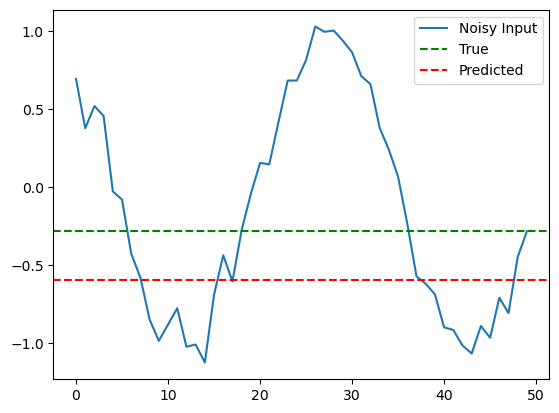

In [11]:
if __name__ == "__main__":
    model = train()
    predict(model)


In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt


def generate_synthetic_multivariate(seq_len=50, num_nodes=5, feat_dim=3):
    """
    Generate synthetic multivariate data for each node.
    """
    t = np.linspace(0, 4 * np.pi, seq_len)
    data = []
    for _ in range(num_nodes):
        node_feats = np.stack([
            np.sin(t + np.random.uniform(0, 2 * np.pi)),
            np.cos(t + np.random.uniform(0, 2 * np.pi)),
            np.sin(2 * t + np.random.uniform(0, 2 * np.pi)),
        ], axis=-1) + 0.1 * np.random.randn(seq_len, feat_dim)
        data.append(node_feats)
    return torch.tensor(np.stack(data, axis=1), dtype=torch.float32)  # (T, N, F)


In [13]:
class KalmanGCNLSTM(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.kalman = KalmanRNNLayer(in_dim, hidden_dim)
        self.gcn = GCNConv(in_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, edge_index):
        """
        x: (B, T, N, F)
        edge_index: (2, E)
        """
        B, T, N, F = x.shape
        x = self.kalman(x)  # (B, T, N, F)

        # Apply GCN on each time step
        gcn_out = []
        for t in range(T):
            x_t = x[:, t]  # (B, N, F)
            #x_t_flat = x_t.view(B * N, F)
            x_t_flat = x_t.reshape(B * N, F)
            edge_index_batch = edge_index.repeat(1, B) + torch.arange(B, device=x.device).repeat_interleave(edge_index.shape[1]) * N
            x_gcn = self.gcn(x_t_flat, edge_index_batch)  # (B * N, hidden)
            x_gcn = x_gcn.view(B, N, -1)
            gcn_out.append(x_gcn.unsqueeze(1))

        x_seq = torch.cat(gcn_out, dim=1)  # (B, T, N, hidden)
        x_seq = x_seq.view(B * N, T, -1)   # For LSTM
        lstm_out, _ = self.lstm(x_seq)
        pred = self.fc(lstm_out[:, -1])   # Last time step
        return pred.view(B, N, -1)


In [14]:
def train_model():
    B, T, N, F = 32, 50, 5, 3
    hidden_dim = 16
    model = KalmanGCNLSTM(F, hidden_dim, F).cuda()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Fully connected graph
    edge_index = torch.combinations(torch.arange(N), r=2).T
    edge_index = torch.cat([edge_index, edge_index[[1, 0]]], dim=1).cuda()

    for epoch in range(100):
        x_batch = torch.stack([generate_synthetic_multivariate(T, N, F) for _ in range(B)]).cuda()
        y_true = x_batch[:, -1]  # Predict final frame

        pred = model(x_batch, edge_index)
        loss = criterion(pred, y_true)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    torch.save(model.state_dict(), "kalman_gcnlstm.pt")
    return model, edge_index


In [15]:
def predict(model, edge_index):
    model.eval()
    with torch.no_grad():
        x = generate_synthetic_multivariate(50, 5, 3).unsqueeze(0).cuda()
        y_true = x[:, -1]
        y_pred = model(x, edge_index)

        print("True (node 0):", y_true[0, 0].cpu().numpy().round(2))
        print("Pred (node 0):", y_pred[0, 0].cpu().numpy().round(2))

        plt.plot(x[0, :, 0, 0].cpu(), label="Node 0, Feature 0")
        plt.axhline(y=y_true[0, 0, 0].item(), color='g', linestyle='--', label="True")
        plt.axhline(y=y_pred[0, 0, 0].item(), color='r', linestyle='--', label="Predicted")
        plt.legend()
        plt.show()


Epoch 0, Loss: 0.4958
Epoch 10, Loss: 0.4997
Epoch 20, Loss: 0.5377
Epoch 30, Loss: 0.5102
Epoch 40, Loss: 0.5223
Epoch 50, Loss: 0.4959
Epoch 60, Loss: 0.5456
Epoch 70, Loss: 0.5087
Epoch 80, Loss: 0.5137
Epoch 90, Loss: 0.5273
True (node 0): [ 0.94 -0.93  0.53]
Pred (node 0): [-0.01  0.    0.01]


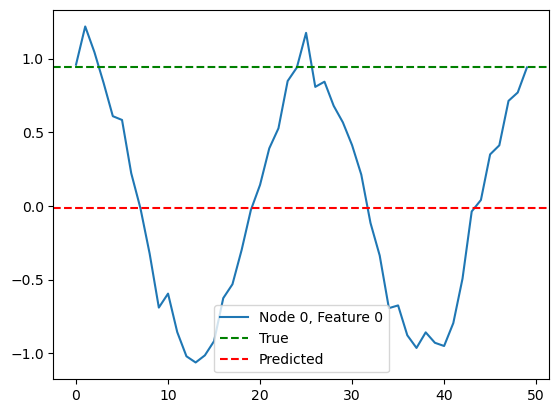

In [16]:
if __name__ == "__main__":
    model, edge_index = train_model()
    predict(model, edge_index)


In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch_geometric.nn import GATConv
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print("Using device:", device)

# === Synthetic Data with Exogenous Inputs ===
def generate_synthetic(T=30, N=5, F=3, U=2):
    t = np.linspace(0, 4 * np.pi, T)
    data = []
    exo = []
    for _ in range(N):
        y = np.stack([
            np.sin(t + np.random.rand()*2*np.pi),
            np.cos(t + np.random.rand()*2*np.pi),
            np.sin(2*t + np.random.rand()*2*np.pi)
        ], axis=-1) + 0.1 * np.random.randn(T, F)
        u = np.random.randn(T, U)
        u[15:] += 1  # Intervention
        data.append(y)
        exo.append(u)
    return (
        torch.tensor(np.stack(data, axis=1), dtype=torch.float32),  # (T, N, F)
        torch.tensor(np.stack(exo, axis=1), dtype=torch.float32)    # (T, N, U)
    )

# === Simple Dynamic Graph ===
def dynamic_edges(T, N):
    seq = []
    for _ in range(T):
        edges = [[i, j] for i in range(N) for j in range(N) if i != j and np.random.rand() < 0.5]
        edge_index = torch.tensor(edges, dtype=torch.long).t() if edges else torch.empty((2, 0), dtype=torch.long)
        seq.append(edge_index)
    return seq

# === Kalman + GAT + LSTM with Exo Input ===
class KalmanRNN(nn.Module):
    def __init__(self, F, U, H):
        super().__init__()
        self.encode = nn.Linear(F + U, H)
        self.rnn = nn.GRU(H, H, batch_first=True)
        self.decode = nn.Linear(H, F)

    def forward(self, z, u):
        B, T, N, _ = z.shape
        x = torch.cat([z, u], dim=-1).view(B*N, T, -1)
        x = self.encode(x)
        h, _ = self.rnn(x)
        return self.decode(h).view(B, T, N, -1)

class GATLSTM(nn.Module):
    def __init__(self, F, U, H, O):
        super().__init__()
        self.kalman = KalmanRNN(F, U, H)
        self.gat = GATConv(F, H, heads=1)
        self.lstm = nn.LSTM(H, H, batch_first=True)
        self.out = nn.Linear(H, O)

    def forward(self, x, u, edge_seq):
        B, T, N, F = x.shape
        x = self.kalman(x, u)
        gcn_seq = []
        for t in range(T):
            x_t = x[:, t].reshape(-1, F)
            edges = edge_seq[t].repeat(1, B) + torch.arange(B).repeat_interleave(edge_seq[t].shape[1]) * N
            out = self.gat(x_t, edges)
            gcn_seq.append(out.view(B, N, -1))
        x_lstm = torch.stack(gcn_seq, dim=1).mean(2)  # (B, T, H)
        _, (h, _) = self.lstm(x_lstm)
        return self.out(h[-1])
        #out = self.out(h[-1]).view(B, N, -1)  # (B, N, F)
        #return out


# === Training ===
def train():
    T, N, F, U = 30, 5, 3, 2
    B = 8
    H = 16
    model = GATLSTM(F, U, H, F)
    opt = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    for epoch in range(100):
        x_batch, u_batch = zip(*[generate_synthetic(T, N, F, U) for _ in range(B)])
        x = torch.stack(x_batch) # (B, T, N, F)
        u = torch.stack(u_batch)  # (B, T, N, U)
        y = x[:, -1, 0]                      # target
        edge_seq = dynamic_edges(T, N)
        edge_seq = [e for e in edge_seq]
        y_pred = model(x, u, edge_seq)
        loss = loss_fn(y_pred, y)

        opt.zero_grad()
        loss.backward()
        opt.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    torch.save(model.state_dict(), "exo_kalman_gcn_lstm.pt")
    return model


In [51]:
import matplotlib.pyplot as plt

def predict(model):
    T, N, F, U = 30, 5, 3, 2
    x, u = generate_synthetic(T, N, F, U)
    x = x.unsqueeze(0)
    u = u.unsqueeze(0)
    edge_seq = dynamic_edges(T, N)
    edge_seq = [e for e in edge_seq]
    model.eval()
    with torch.no_grad():
        y_pred = model(x, u, edge_seq).numpy()
        y_true = x[0, -1].numpy()

    print("True[0]:", y_true[0].round(2))
    print("Pred[0]:", y_pred[0].round(2))

    plt.plot(x[0, :, 0, 0], label="Feature 0 - Node 0")
    plt.axhline(y=y_true[0, 0], color="g", linestyle="--", label="True Final")
    plt.axhline(y=y_pred[0, 0], color="r", linestyle="--", label="Predicted")
    plt.legend()
    plt.title("Prediction with Exogenous Signal")
    plt.show()


Epoch 0, Loss: 0.5243
Epoch 10, Loss: 0.6370
Epoch 20, Loss: 0.4097
Epoch 30, Loss: 0.4191
Epoch 40, Loss: 0.5502
Epoch 50, Loss: 0.4812
Epoch 60, Loss: 0.4814
Epoch 70, Loss: 0.5747
Epoch 80, Loss: 0.4633
Epoch 90, Loss: 0.4872
True[0]: [-1.13  0.8   1.04]
Pred[0]: [0.   0.01 0.  ]


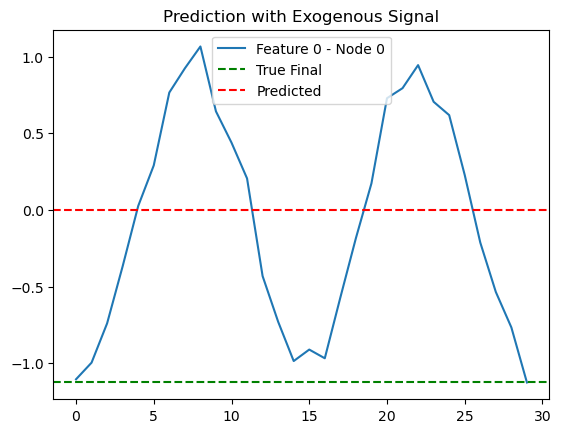

In [52]:
model = train()
predict(model)

In [84]:
from torch_geometric.nn import GATConv

class DynamicGATLSTM(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, heads=2):
        super().__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.kalman = KalmanRNNLayer(in_dim, hidden_dim)
        self.gat = GATConv(in_dim, hidden_dim, heads=heads, concat=False)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.temporal_attn = nn.MultiheadAttention(hidden_dim, num_heads=2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, edge_index_seq):
        """
        x: (B, T, N, F)
        edge_index_seq: list of length T with each entry of shape (2, E)
        """
        B, T, N, F = x.shape
        x = self.kalman(x)  # (B, T, N, F)

        gcn_out = []
        '''for t in range(T):
            x_t = x[:, t]  # (B, N, F)
            x_t_flat = x_t.reshape(B * N, F)
            edge_index = edge_index_seq[t]
            edge_index = edge_index.repeat(1, B) + torch.arange(B, device=x.device).repeat_interleave(edge_index.shape[1]) * N
            x_gat = self.gat(x_t_flat, edge_index)
            gcn_out.append(x_gat.view(B, N, -1).unsqueeze(1))  # (B, 1, N, H)'''
        for t in range(T):
            gat_t = []
            for b in range(B):
                x_t = x[b, t]  # (N, F)
                try:
                    edge_index = edge_index_seq[b][t]  # (2, E)
                    if edge_index.dim() != 2 or edge_index.shape[0] != 2:
                        continue
                    x_gat = self.gat(x_t, edge_index)  # (N, hidden_dim)
                    gat_t.append(x_gat.unsqueeze(0))  # (1, N, hidden_dim)
                except:
                    True
            if len(gat_t)==0:
                continue
            gat_t = torch.cat(gat_t, dim=0)  # (B, N, hidden_dim)
            gcn_out.append(gat_t.unsqueeze(1))  # (B, 1, N, hidden_dim)


        x_seq = torch.cat(gcn_out, dim=1)  # (B, T, N, H)
        x_seq = x_seq.permute(0, 2, 1, 3).reshape(B * N, T, -1)  # (B*N, T, H)

        lstm_out, _ = self.lstm(x_seq)  # (B*N, T, H)

        # Apply temporal attention
        attn_out, _ = self.temporal_attn(lstm_out, lstm_out, lstm_out)  # (B*N, T, H)
        y_pred = self.fc(attn_out[:, -1])  # (B*N, out_dim)
        return y_pred.view(B, N, -1)
    '''def forward(self, x, edge_index_seq):
        # x: (B, T, N, F)
        B, T, N, F = x.shape
        outputs = []

        for b in range(B):
            h = torch.zeros(N, self.hidden_dim).to(x.device)
            c = torch.zeros(N, self.hidden_dim).to(x.device)
            lstm_out = []

            for t in range(T):
                xt = x[b, t]  # (N, F)
                edge_index = edge_index_seq[b][t]  # (2, E)
                xt = self.gat(xt, edge_index)  # GATConv: (N, hidden_dim)
                h, c = self.lstm(xt, (h, c))  # (N, hidden_dim)
                lstm_out.append(h)

            lstm_out = torch.stack(lstm_out, dim=0)  # (T, N, hidden_dim)
            outputs.append(lstm_out)

        outputs = torch.stack(outputs, dim=0)  # (B, T, N, hidden_dim)
        return self.out_proj(outputs[:, -1])  # (B, N, out_features)'''



In [85]:
def generate_dynamic_edge_index_seq(T, N, p_connect=0.5):
    """
    Returns a list of T tensors, each of shape (2, E), where E is the number of edges.
    """
    edge_index_seq = []
    for _ in range(T):
        edges = []
        for i in range(N):
            for j in range(N):
                if i != j and np.random.rand() < p_connect:
                    edges.append([i, j])

        if len(edges) == 0:
            edge_index = torch.empty((2, 0), dtype=torch.long)
        else:
            # Ensure edges is 2D: (E, 2)
            edge_array = np.array(edges)
            if edge_array.ndim != 2 or edge_array.shape[1] != 2:
                raise ValueError(f"Malformed edges list: {edge_array}")
            edge_index = torch.tensor(edge_array.T, dtype=torch.long).contiguous()  # Shape (2, E)

        edge_index_seq.append(edge_index)

    return edge_index_seq


In [86]:
def train_dynamic_model():
    B, T, N, F = 16, 30, 5, 3
    hidden_dim = 32
    model = DynamicGATLSTM(F, hidden_dim, F)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(10):
        x_batch = torch.stack([generate_synthetic_multivariate(T, N, F) for _ in range(B)])  # (B, T, N, F)
        edge_index_seq = [generate_dynamic_edge_index_seq(T, N) for _ in range(B)]  # List[B][T][2, E]

        y_true = x_batch[:, -1]  # (B, N, F), target is last step

        y_pred = model(x_batch, edge_index_seq)  # (B, N, F)
        loss = criterion(y_pred, y_true)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

    torch.save(model.state_dict(), "dynamic_kalman_gat.pt")
    return model


In [87]:
def predict_dynamic(model):
    model.eval()
    with torch.no_grad():
        #x = generate_synthetic_multivariate(30, 5, 3).unsqueeze(0).cuda()
        x = generate_synthetic_multivariate(30, 5, 3).unsqueeze(0)
        edge_index_seq = generate_dynamic_edge_index_seq(30, 5)
        edge_index_seq = [e for e in edge_index_seq]
        y_true = x[:, -1]
        y_pred = model(x, edge_index_seq)

        print("True (node 0):", y_true[0, 0].numpy().round(2))
        print("Pred (node 0):", y_pred[0, 0].numpy().round(2))

        plt.plot(x[0, :, 0, 0].cpu(), label="Node 0, Feature 0")
        plt.axhline(y=y_true[0, 0, 0].item(), color='g', linestyle='--', label="True")
        plt.axhline(y=y_pred[0, 0, 0].item(), color='r', linestyle='--', label="Predicted")
        plt.legend()
        plt.show()


In [88]:
if __name__ == "__main__":
    model = train_dynamic_model()
    predict_dynamic(model)


Epoch 0 | Loss: 0.5190


RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [21]:
class ExoDynamicGATLSTM(nn.Module):
    def __init__(self, in_dim, control_dim, hidden_dim, out_dim):
        super().__init__()
        self.kalman = KalmanRNNLayer(in_dim, control_dim, hidden_dim)
        self.gat = GATConv(in_dim, hidden_dim, heads=2, concat=False)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.temporal_attn = nn.MultiheadAttention(hidden_dim, num_heads=2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, u, edge_index_seq):
        """
        x: (B, T, N, F)
        u: (B, T, N, U)
        edge_index_seq: list of T edge_index tensors
        """
        B, T, N, F = x.shape
        x = self.kalman(x, u)

        gcn_out = []
        for t in range(T):
            x_t = x[:, t]  # (B, N, F)
            x_t_flat = x_t.reshape(B * N, F)
            edge_index = edge_index_seq[t].repeat(1, B) + torch.arange(B, device=x.device).repeat_interleave(edge_index_seq[t].shape[1]) * N
            x_gat = self.gat(x_t_flat, edge_index)
            gcn_out.append(x_gat.view(B, N, -1).unsqueeze(1))

        x_seq = torch.cat(gcn_out, dim=1).permute(0, 2, 1, 3).reshape(B * N, T, -1)
        lstm_out, _ = self.lstm(x_seq)
        attn_out, _ = self.temporal_attn(lstm_out, lstm_out, lstm_out)
        y_pred = self.fc(attn_out[:, -1])
        return y_pred.view(B, N, -1)


In [22]:
def generate_synthetic_multivariate_with_exo(seq_len=30, num_nodes=5, feat_dim=3, exo_dim=2):
    t = np.linspace(0, 4 * np.pi, seq_len)
    data, exo = [], []
    for _ in range(num_nodes):
        node_feats = np.stack([
            np.sin(t + np.random.uniform(0, 2 * np.pi)),
            np.cos(t + np.random.uniform(0, 2 * np.pi)),
            np.sin(2 * t + np.random.uniform(0, 2 * np.pi)),
        ], axis=-1) + 0.1 * np.random.randn(seq_len, feat_dim)
        exo_feats = np.random.randn(seq_len, exo_dim)
        # simulate an intervention at t = 15
        exo_feats[15:] += 1.0
        data.append(node_feats)
        exo.append(exo_feats)

    return (
        torch.tensor(np.stack(data, axis=1), dtype=torch.float32),  # (T, N, F)
        torch.tensor(np.stack(exo, axis=1), dtype=torch.float32)   # (T, N, U)
    )


In [25]:
x_batch, u_batch = zip(*[generate_synthetic_multivariate_with_exo(T, N, F, U) for _ in range(B)])
x_batch = torch.stack(x_batch).cuda()  # (B, T, N, F)
u_batch = torch.stack(u_batch).cuda()  # (B, T, N, U)
y_pred = model(x_batch, u_batch, edge_index_seq_batched)

NameError: name 'B' is not defined

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class KalmanNet(nn.Module):
    def __init__(self, obs_dim, state_dim, hidden_dim=128):
        """
        obs_dim: dimension of the observation y_t
        state_dim: dimension of the hidden state x_t
        hidden_dim: internal processing dimension
        """
        super(KalmanNet, self).__init__()
        self.obs_dim = obs_dim
        self.state_dim = state_dim

        # State prediction network (prior estimate)
        self.predict_net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, state_dim)
        )

        # Kalman gain network (learns gain from observation and prediction)
        self.kgain_net = nn.Sequential(
            nn.Linear(obs_dim + state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, state_dim * obs_dim)  # gain matrix flattened
        )

        # Observation model (H): maps state space to observed space
        self.H = nn.Linear(state_dim, obs_dim)

        # Initial state
        self.x_prior = nn.Parameter(torch.zeros(state_dim))

    def forward(self, observations):
        """
        observations: Tensor of shape (batch, time, obs_dim)
        """
        batch_size, time_steps, _ = observations.shape
        x_estimates = []

        x_t = self.x_prior.expand(batch_size, -1)  # Initialize state estimate

        for t in range(time_steps):
            y_t = observations[:, t, :]  # Current observation

            # 1. Predict state: x_t^- = f(x_{t-1})
            x_pred = self.predict_net(x_t)

            # 2. Predict observation: y_pred = H x_t^-
            y_pred = self.H(x_pred)

            # 3. Innovation: residual = y_t - y_pred
            residual = y_t - y_pred

            # 4. Kalman gain from observation + prediction
            kgain_input = torch.cat([y_t, x_pred], dim=-1)
            K_t = self.kgain_net(kgain_input)  # shape: (batch, state_dim * obs_dim)
            K_t = K_t.view(batch_size, self.state_dim, self.obs_dim)

            # 5. Update: x_t = x_pred + K_t * residual
            residual = residual.unsqueeze(-1)  # (batch, obs_dim, 1)
            correction = torch.bmm(K_t, residual).squeeze(-1)  # (batch, state_dim)
            x_t = x_pred + correction

            x_estimates.append(x_t.unsqueeze(1))

        return torch.cat(x_estimates, dim=1)  # (batch, time, state_dim)


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class KalmanRNNCell(nn.Module):
    def __init__(self, state_dim, obs_dim, exog_dim):
        super().__init__()
        self.state_dim = state_dim
        self.obs_dim = obs_dim
        self.exog_dim = exog_dim

        # Learnable system matrices
        self.A = nn.Parameter(torch.eye(state_dim) + 0.01*torch.randn(state_dim, state_dim))
        self.B = nn.Parameter(0.01*torch.randn(state_dim, exog_dim))
        self.C = nn.Parameter(0.01*torch.randn(obs_dim, state_dim))
        self.Q = nn.Parameter(torch.eye(state_dim) * 0.01)
        self.R = nn.Parameter(torch.eye(obs_dim) * 0.01)

    def forward(self, x_t, u_t, h_prev):
        # x_t: (batch, nodes, obs_dim)
        # u_t: (batch, nodes, exog_dim)
        # h_prev: (batch, nodes, state_dim)

        # Predict step
        pred_h = torch.matmul(h_prev, self.A.T) + torch.matmul(u_t, self.B.T)  # (batch, nodes, state_dim)

        # Innovation
        pred_x = torch.matmul(pred_h, self.C.T)  # (batch, nodes, obs_dim)
        y = x_t - pred_x

        # Kalman gain
        # For simplicity, use learned scalar gain or identity scaled (could be extended)
        # Here, identity scaled
        gain = torch.eye(self.state_dim, device=x_t.device).unsqueeze(0).unsqueeze(0)  # (1,1,state_dim,state_dim)
        gain = gain.expand(x_t.shape[0], x_t.shape[1], -1, -1)  # (batch, nodes, state_dim, state_dim)
        #gain = gain.repeat(x_t.shape[0], x_t.shape[1], 1, 1)


        # Flatten h_prev for matrix operations
        y = y.unsqueeze(-1)  # (batch, nodes, obs_dim, 1)
        C = self.C.unsqueeze(0).unsqueeze(0)  # (1,1,obs_dim,state_dim)

        # Compute correction term
        correction = torch.matmul(gain, torch.matmul(C.transpose(-2,-1), y))  # (batch,nodes,state_dim,1)
        correction = correction.squeeze(-1)

        h_new = pred_h + correction
        return h_new


In [11]:
class KalmanRNN(nn.Module):
    def __init__(self, state_dim, obs_dim, exog_dim):
        super().__init__()
        self.cell = KalmanRNNCell(state_dim, obs_dim, exog_dim)

    def forward(self, X, U):
        # X: (batch, nodes, seq_len, obs_dim)
        # U: (batch, nodes, seq_len, exog_dim)
        batch_size, nodes, seq_len, _ = X.shape
        h = torch.zeros(batch_size, nodes, self.cell.state_dim, device=X.device)
        h_seq = []
        for t in range(seq_len):
            h = self.cell(X[:,:,t,:], U[:,:,t,:], h)
            h_seq.append(h.unsqueeze(2))
        return torch.cat(h_seq, dim=2)  # (batch, nodes, seq_len, state_dim)


In [ ]:
class KalmanAgg(nn.Module):
    def __init__(self, state_dim, obs_dim, exog_dim):
        super().__init__()
        self.kalman_cell = KalmanRNNCell(state_dim, obs_dim, exog_dim)
        self.attn_fc = nn.Linear(2*state_dim, 1)  # for attention scoring

    def forward(self, h, edge_index, edge_attr, U):
        # h: (batch, nodes, state_dim)
        # edge_index: (2, num_edges)
        # edge_attr: edge features (optional), not used here
        # U: (batch, nodes, exog_dim) exogenous inputs per node

        batch_size, num_nodes, state_dim = h.shape
        device = h.device

        # Prepare attention inputs for each edge
        src, dst = edge_index  # shape (num_edges,)
        src_h = h[:, src, :]   # (batch, num_edges, state_dim)
        dst_h = h[:, dst, :]   # (batch, num_edges, state_dim)
        attn_input = torch.cat([src_h, dst_h], dim=-1)  # (batch, num_edges, 2*state_dim)

        attn_scores = self.attn_fc(attn_input).squeeze(-1)  # (batch, num_edges)
        attn_weights = torch.softmax(attn_scores, dim=1)   # normalized attention

        # Kalman aggregation per destination node:
        h_new = torch.zeros_like(h)

        # Aggregate messages with Kalman cell
        for b in range(batch_size):
            # For each dst node, collect neighbor src nodes
            for node in range(num_nodes):
                neighbors = (dst == node).nonzero(as_tuple=True)[0]
                if len(neighbors) == 0:
                    # no neighbors, copy own state
                    h_new[b,node] = h[b,node]
                    continue

                # Sum Kalman corrections for neighbors
                neighbor_states = src_h[b, neighbors, :]  # (num_neighbors, state_dim)
                neighbor_U = U[b, src[neighbors], :]      # (num_neighbors, exog_dim)
                node_state = h[b, node].unsqueeze(0).repeat(len(neighbors), 1)  # (num_neighbors, state_dim)

                # Apply Kalman update for each neighbor->node
                updated_states = []
                for i in range(len(neighbors)):
                    updated = self.kalman_cell(neighbor_states[i].unsqueeze(0), neighbor_U[i].unsqueeze(0), node_state[i].unsqueeze(0))
                    #updated_states.append(updated.squeeze(0))
                    updated_states.append(updated.view(-1))  # flattens to [state_dim]
                updated_states = torch.stack(updated_states)  # (num_neighbors, state_dim)

                # Weighted sum by attention
                #weights = attn_weights[b, neighbors].unsqueeze(-1)
                #h_new[b, node] = torch.sum(weights * updated_states, dim=0)
                if len(neighbors) == 0:
                    h_new[b, node] = h[b, node]
                else:
                    weights = attn_weights[b, neighbors].unsqueeze(-1)  # shape (num_neighbors, 1)
                    agg = torch.sum(weights * updated_states, dim=0)
                    h_new[b, node] = agg.view(-1)  # ensures shape [state_dim]

                    #h_new[b, node] = torch.sum(weights * updated_states, dim=0)

        return h_new


In [27]:
class DynamicGAT(nn.Module):
    def __init__(self, state_dim, obs_dim, exog_dim, edge_index):
        super().__init__()
        self.kalman_agg = KalmanAgg(state_dim, obs_dim, exog_dim)
        self.edge_index = edge_index

    def forward(self, h_seq, U_seq):
        # h_seq: (batch, nodes, seq_len, state_dim)
        # U_seq: (batch, nodes, seq_len, exog_dim)
        batch_size, nodes, seq_len, state_dim = h_seq.shape
        h_new_seq = []
        for t in range(seq_len):
            h_t = h_seq[:, :, t, :]  # (batch, nodes, state_dim)
            U_t = U_seq[:, :, t, :]  # (batch, nodes, exog_dim)
            h_new = self.kalman_agg(h_t, self.edge_index, None, U_t)  # (batch, nodes, state_dim)
            h_new_seq.append(h_new.unsqueeze(2))
        return torch.cat(h_new_seq, dim=2)


In [28]:
class TemporalLSTM(nn.Module):
    def __init__(self, state_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(state_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)  # output 1 feature prediction per node

    def forward(self, h_seq):
        # h_seq: (batch, nodes, seq_len, state_dim)
        batch_size, nodes, seq_len, state_dim = h_seq.shape
        h_seq = h_seq.permute(0, 1, 2, 3).reshape(batch_size*nodes, seq_len, state_dim)
        out, _ = self.lstm(h_seq)
        out = self.fc(out)  # (batch*nodes, seq_len, 1)
        out = out.reshape(batch_size, nodes, seq_len, 1)
        return out


In [29]:
class FullModel(nn.Module):
    def __init__(self, state_dim, obs_dim, exog_dim, edge_index, lstm_hidden_dim):
        super().__init__()
        self.kalman_rnn = KalmanRNN(state_dim, obs_dim, exog_dim)
        self.dynamic_gat = DynamicGAT(state_dim, obs_dim, exog_dim, edge_index)
        self.temporal_lstm = TemporalLSTM(state_dim, lstm_hidden_dim)

    def forward(self, X, U):
        # X: (batch, nodes, seq_len, obs_dim)
        # U: (batch, nodes, seq_len, exog_dim)

        h_smooth = self.kalman_rnn(X, U)                    # Kalman smoothing
        h_agg = self.dynamic_gat(h_smooth, U)               # Graph aggregation with Kalman agg + attention
        out = self.temporal_lstm(h_agg)                     # Temporal LSTM modeling
        return out.squeeze(-1)  # shape (batch, nodes, seq_len)


In [30]:
@torch.no_grad()
def predict(model, X, U):
    """
    Predicts outputs from input time series X with exogenous inputs U using the trained model.

    Args:
        model: Trained FullModel instance
        X: Tensor, shape (batch, nodes, seq_len, obs_dim)
        U: Tensor, shape (batch, nodes, seq_len, exog_dim)

    Returns:
        predictions: Tensor of shape (batch, nodes, seq_len) - predicted node values over time
    """
    model.eval()
    preds = model(X, U)  # output shape (batch, nodes, seq_len)
    return preds


In [31]:
import numpy as np

def evaluate_predictions(y_true, y_pred):
    """
    Compute MAE, RMSE, and MAPE between ground truth and predictions.

    Args:
        y_true: np.array or tensor of shape (batch, nodes, seq_len)
        y_pred: np.array or tensor same shape as y_true

    Returns:
        dict of metrics { 'MAE': ..., 'RMSE': ..., 'MAPE': ... }
    """
    if torch.is_tensor(y_true):
        y_true = y_true.detach().cpu().numpy()
    if torch.is_tensor(y_pred):
        y_pred = y_pred.detach().cpu().numpy()

    mask = y_true != 0  # avoid division by zero for MAPE
    mae = np.mean(np.abs(y_pred - y_true))
    rmse = np.sqrt(np.mean((y_pred - y_true)**2))
    mape = np.mean(np.abs((y_pred - y_true) / y_true)[mask]) * 100

    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}


In [ ]:
import h5py
import numpy as np
import pandas as pd
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# ------- Dataset class --------
class METR_LADataset(Dataset):
    def __init__(self, data, adj, exog=None, seq_len=12, pred_len=12):
        """
        data: np.array (nodes, timesteps, features)
        adj: np.array (nodes, nodes)
        exog: np.array (timesteps, exog_features)
        seq_len: length of input sequence
        pred_len: length of prediction horizon
        """
        self.data = data
        self.adj = adj
        self.exog = exog
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.num_nodes = data.shape[0]
        self.num_timesteps = data.shape[1]
        self.feature_dim = data.shape[2]

    def __len__(self):
        return self.num_timesteps - self.seq_len - self.pred_len + 1

    def __getitem__(self, idx):
        # shape: nodes x seq_len x features
        X = self.data[:, idx:idx+self.seq_len, :]
        Y = self.data[:, idx+self.seq_len:idx+self.seq_len+self.pred_len, 0]  # predict first feature (e.g., speed)

        if self.exog is not None:
            U = self.exog[idx:idx+self.seq_len+self.pred_len]
            U_seq = U[:self.seq_len]
            U_pred = U[self.seq_len:self.seq_len+self.pred_len]
            # Repeat exog for each node for simplicity
            U_seq = np.repeat(U_seq[np.newaxis, :, :], self.num_nodes, axis=0)
            U_pred = np.repeat(U_pred[np.newaxis, :, :], self.num_nodes, axis=0)
        else:
            U_seq = np.zeros((self.num_nodes, self.seq_len, 0))
            U_pred = np.zeros((self.num_nodes, self.pred_len, 0))

        return (torch.tensor(X, dtype=torch.float32),
                torch.tensor(U_seq, dtype=torch.float32),
                torch.tensor(Y, dtype=torch.float32))

# ------- Load METR-LA data --------
def load_metr_la_data(h5_path):
    with h5py.File(h5_path, 'r') as f:
        data = pd.read_hdf(h5_path) # shape (nodes, timesteps, features)
    return data

# ------- Load adjacency --------
def load_adj(adj_path):
    with open(adj_path, 'rb') as f:
        adj = pickle.load(f, encoding='latin1')
    return adj

# ------- Exogenous features (time) -------
def create_time_exog(num_timesteps):
    # Simple: hour of day (one-hot encoded)
    hours = np.arange(num_timesteps) % 24
    exog = np.eye(24)[hours]  # shape (num_timesteps, 24)
    return exog.astype(np.float32)

# ------- Collate for DataLoader -------
def collate_fn(batch):
    X = torch.stack([item[0] for item in batch])
    U = torch.stack([item[1] for item in batch])
    Y = torch.stack([item[2] for item in batch])
    return X, U, Y


# ------- Train and eval functions --------
def train_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for X, U, Y in dataloader:
        X, U, Y = X.to(device), U.to(device), Y.to(device)
        optimizer.zero_grad()
        output = model(X, U)  # output shape: batch, nodes, seq_len (or pred_len)
        # Match prediction horizon with Y: e.g. last pred_len steps
        loss = loss_fn(output[:, :, -Y.shape[2]:], Y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    maes, rmses, mapes = [], [], []
    for X, U, Y in dataloader:
        X, U, Y = X.to(device), U.to(device), Y.to(device)
        preds = model(X, U)[:, :, -Y.shape[2]:]
        preds = preds.cpu().numpy()
        Y = Y.cpu().numpy()
        mask = Y != 0
        mae = np.mean(np.abs(preds - Y))
        rmse = np.sqrt(np.mean((preds - Y) ** 2))
        mape = np.mean(np.abs((preds - Y)[mask] / Y[mask])) * 100
        maes.append(mae)
        rmses.append(rmse)
        mapes.append(mape)
    return np.mean(maes), np.mean(rmses), np.mean(mapes)

def distance_to_weight(
        W: torch.tensor,
        sigma2: float = 0.1,
        epsilon: float = 0.5,
        gat_version: bool = False,
    ):
        num_nodes = W.shape[0]
        BASE_KM = 10_000.0
        W = W / BASE_KM
        W2 = W * W
        W_mask = torch.ones([num_nodes, num_nodes]) - torch.eye(num_nodes)
        W = (
            torch.exp(-W2 / sigma2)
            * (torch.exp(-W2 / sigma2) >= epsilon)
            * W_mask
        )

        if gat_version:
            W[W > 0] = 1
            W += torch.eye(num_nodes)

        return W

# ------- Main --------
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load data
    data = load_metr_la_data('METR-LA.h5')  # (nodes, timesteps, features)
    #adj = load_adj('adj_METR-LA.pkl')
    *_, adj = pd.read_pickle('adj_METR-LA.pkl')
    if isinstance(data, pd.DataFrame) or isinstance(data, pd.Series):
      data = data.values

    W = distance_to_weight(torch.from_numpy(adj), gat_version=True)
    _, num_nodes = data.shape
    edge_index = torch.zeros((2, num_nodes**2), dtype=torch.long)
    edge_label = torch.zeros((num_nodes**2, 2))
    num_edges = 0
    # extract edge list from adjacency matrix
    for i in range(num_nodes):
        for j in range(num_nodes):
            if W[i, j] != 0:
                edge_index[0, num_edges] = i
                edge_index[1, num_edges] = j
                edge_label[num_edges] = W[i, j]
                num_edges += 1


    # Now data is numpy ndarray, you can reshape or add dims safely
    if data.ndim == 2:
        data = data.T  # or as needed
        data = data[:, :, None]  # add feature axis
    # Normalize features per node
    scaler = StandardScaler()
    nodes, timesteps, features = data.shape
    data_reshaped = data.reshape(nodes * timesteps, features)
    data_norm = scaler.fit_transform(data_reshaped).reshape(nodes, timesteps, features)

    # Exogenous features
    exog = create_time_exog(timesteps)

    # Split data indices for train/val/test
    train_ratio, val_ratio = 0.7, 0.1
    train_end = int(timesteps * train_ratio)
    val_end = int(timesteps * (train_ratio + val_ratio))

    seq_len = 12
    pred_len = 12

    train_dataset = METR_LADataset(data_norm[:, :train_end, :], adj, exog=exog[:train_end], seq_len=seq_len, pred_len=pred_len)
    val_dataset = METR_LADataset(data_norm[:, train_end - seq_len - pred_len:val_end, :], adj, exog=exog[train_end - seq_len - pred_len:val_end], seq_len=seq_len, pred_len=pred_len)
    test_dataset = METR_LADataset(data_norm[:, val_end - seq_len - pred_len:, :], adj, exog=exog[val_end - seq_len - pred_len:], seq_len=seq_len, pred_len=pred_len)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

    # Model parameters — adjust as needed
    input_dim = features
    exog_dim = exog.shape[1]
    hidden_dim = 64
    num_nodes = nodes

    # Your FullModel should be defined with inputs: input_dim, exog_dim, hidden_dim, adj, etc.

    model = FullModel(input_dim, num_nodes, exog_dim, edge_index, hidden_dim).to(device)


    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = torch.nn.MSELoss()

    epochs = 30

    for epoch in range(1, epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, loss_fn, device)
        val_mae, val_rmse, val_mape = evaluate(model, val_loader, device)
        print(f"Epoch {epoch} - Train Loss: {train_loss:.4f} | Val MAE: {val_mae:.4f} | Val RMSE: {val_rmse:.4f} | Val MAPE: {val_mape:.2f}%")

    # Final test evaluation
    test_mae, test_rmse, test_mape = evaluate(model, test_loader, device)
    print(f"Test MAE: {test_mae:.4f} | Test RMSE: {test_rmse:.4f} | Test MAPE: {test_mape:.2f}%")

if __name__ == "__main__":
    main()


weights shape: torch.Size([207, 1])
updated_states shape: torch.Size([207, 1])
sum shape: torch.Size([1])
weights shape: torch.Size([207, 1])
updated_states shape: torch.Size([207, 1])
sum shape: torch.Size([1])
weights shape: torch.Size([207, 1])
updated_states shape: torch.Size([207, 1])
sum shape: torch.Size([1])
weights shape: torch.Size([207, 1])
updated_states shape: torch.Size([207, 1])
sum shape: torch.Size([1])
weights shape: torch.Size([207, 1])
updated_states shape: torch.Size([207, 1])
sum shape: torch.Size([1])
weights shape: torch.Size([207, 1])
updated_states shape: torch.Size([207, 1])
sum shape: torch.Size([1])
weights shape: torch.Size([207, 1])
updated_states shape: torch.Size([207, 1])
sum shape: torch.Size([1])
weights shape: torch.Size([207, 1])
updated_states shape: torch.Size([207, 1])
sum shape: torch.Size([1])
weights shape: torch.Size([207, 1])
updated_states shape: torch.Size([207, 1])
sum shape: torch.Size([1])
weights shape: torch.Size([207, 1])
updated_st

In [26]:
import os
import h5py
import pickle
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# 1. Dataset Class
class METRLADataset(Dataset):
    def __init__(self, data, adj, exog=None, seq_len=12, pred_len=12):
        """
        data: np.array (nodes, timesteps, features)
        adj: np.array (nodes, nodes)
        exog: np.array (timesteps, exog_features)
        """
        self.data = data
        self.adj = adj
        self.exog = exog
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.num_nodes = data.shape[0]
        self.num_timesteps = data.shape[1]
        self.feature_dim = data.shape[2]

    def __len__(self):
        return self.num_timesteps - self.seq_len - self.pred_len + 1

    def __getitem__(self, idx):
        X = self.data[:, idx:idx+self.seq_len, :]
        Y = self.data[:, idx+self.seq_len:idx+self.seq_len+self.pred_len, 0]  # predict speed only

        if self.exog is not None:
            U = self.exog[idx:idx+self.seq_len+self.pred_len]
            U_seq = U[:self.seq_len]
            U_pred = U[self.seq_len:self.seq_len+self.pred_len]
            U_seq = np.repeat(U_seq[np.newaxis, :, :], self.num_nodes, axis=0)
            U_pred = np.repeat(U_pred[np.newaxis, :, :], self.num_nodes, axis=0)
        else:
            U_seq = np.zeros((self.num_nodes, self.seq_len, 0))
            U_pred = np.zeros((self.num_nodes, self.pred_len, 0))

        return (
            torch.tensor(X, dtype=torch.float32),        # (nodes, seq_len, features)
            torch.tensor(U_seq, dtype=torch.float32),    # (nodes, seq_len, exog)
            torch.tensor(Y, dtype=torch.float32),        # (nodes, pred_len)
        )

# 2. Adjacency Loader
def load_adj(path):
    with open(path, 'rb') as f:
        adj = pickle.load(f, encoding='latin1')
    return adj

# 3. Exogenous Feature Generator
def create_time_exog(num_timesteps):
    hours = np.arange(num_timesteps) % 24
    exog = np.eye(24)[hours]
    return exog.astype(np.float32)

# 4. METR-LA Loader
def load_metrla_h5(h5_path):
    with h5py.File(h5_path, 'r') as f:
        data = f['df'][:]
    return data

def load_metrla_dataframe(path):
    df = pd.read_hdf(path)
    return df.values

# 5. Dataset + Dataloader Setup
def prepare_dataloaders(
    data_path, adj_path, batch_size=64,
    seq_len=12, pred_len=12, exog_type="time",
    use_h5=False
):
    # Load data
    if use_h5:
        data = load_metrla_h5(data_path)
    else:
        data = load_metrla_dataframe(data_path)

    if data.ndim == 2:
        data = data.T[:, :, None]  # (nodes, timesteps, features)

    adj = load_adj(adj_path)

    nodes, timesteps, features = data.shape
    scaler = StandardScaler()
    reshaped = data.reshape(nodes * timesteps, features)
    norm_data = scaler.fit_transform(reshaped).reshape(nodes, timesteps, features)

    # Exogenous inputs
    exog = create_time_exog(timesteps) if exog_type == "time" else None

    # Split
    train_ratio, val_ratio = 0.7, 0.1
    train_end = int(train_ratio * timesteps)
    val_end = int((train_ratio + val_ratio) * timesteps)

    train_ds = METRLADataset(norm_data[:, :train_end, :], adj, exog=exog[:train_end], seq_len=seq_len, pred_len=pred_len)
    val_ds   = METRLADataset(norm_data[:, train_end - seq_len - pred_len:val_end, :], adj, exog=exog[train_end - seq_len - pred_len:val_end], seq_len=seq_len, pred_len=pred_len)
    test_ds  = METRLADataset(norm_data[:, val_end - seq_len - pred_len:, :], adj, exog=exog[val_end - seq_len - pred_len:], seq_len=seq_len, pred_len=pred_len)

    # Dataloaders
    def collate_fn(batch):
        X = torch.stack([b[0] for b in batch])
        U = torch.stack([b[1] for b in batch])
        Y = torch.stack([b[2] for b in batch])
        return X, U, Y

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_loader, val_loader, test_loader, scaler

# 6. Example use
if __name__ == "__main__":
    train_loader, val_loader, test_loader, scaler = prepare_dataloaders(
        data_path="METR-LA.h5",  # or .h5 or .hdf
        adj_path="adj_METR-LA.pkl",
        batch_size=64,
        seq_len=12,
        pred_len=12,
        use_h5=False
    )

    for X, U, Y in train_loader:
        print("Batch X:", X.shape)  # (batch, nodes, seq_len, features)
        print("Batch U:", U.shape)  # (batch, nodes, seq_len, exog)
        print("Batch Y:", Y.shape)  # (batch, nodes, pred_len)
        break


Batch X: torch.Size([64, 207, 12, 1])
Batch U: torch.Size([64, 207, 12, 24])
Batch Y: torch.Size([64, 207, 12])


In [27]:
# kalmannet.py
import torch
import torch.nn as nn

'''
class KalmanRNN(nn.Module):
    def __init__(self, state_dim, obs_dim, exog_dim):
        super().__init__()
        self.A = nn.Parameter(torch.eye(state_dim))
        self.B = nn.Parameter(torch.randn(state_dim, exog_dim))
        self.C = nn.Parameter(torch.randn(obs_dim, state_dim))
        self.Q = nn.Parameter(torch.eye(state_dim))
        self.R = nn.Parameter(torch.eye(obs_dim))
        self.gru = nn.GRU(obs_dim + exog_dim, state_dim, batch_first=True)

    def forward(self, Y, U):
        batch, nodes, T, obs_dim = Y.shape
        _, _, _, exog_dim = U.shape
        YU = torch.cat([Y, U], dim=-1)
        YU = YU.view(batch * nodes, T, obs_dim + exog_dim)
        h0 = torch.zeros(1, batch * nodes, self.A.shape[0]).to(Y.device)
        h, _ = self.gru(YU, h0)
        h = h.view(batch, nodes, T, -1)
        return h'''

class KalmanRNN(nn.Module):
    def __init__(self, state_dim, obs_dim, exog_dim):
        super().__init__()
        self.A = nn.Parameter(torch.eye(state_dim))
        self.B = nn.Parameter(torch.randn(state_dim, exog_dim) * 0.01)
        self.C = nn.Parameter(torch.randn(obs_dim, state_dim) * 0.01)
        self.Q = nn.Parameter(torch.eye(state_dim))  # Optional
        self.R = nn.Parameter(torch.eye(obs_dim))    # Optional

        self.gru = nn.GRU(obs_dim + exog_dim, state_dim, batch_first=True)

    def forward(self, Y, U):
        batch, nodes, T, obs_dim = Y.shape
        _, _, _, exog_dim = U.shape

        # Concatenate observations and exogenous inputs
        YU = torch.cat([Y, U], dim=-1)
        YU = YU.view(batch * nodes, T, obs_dim + exog_dim)

        h0 = torch.zeros(1, batch * nodes, self.A.shape[0]).to(Y.device)
        h, _ = self.gru(YU, h0)
        h = h.view(batch, nodes, T, -1)

        # Apply transition dynamics
        h = torch.matmul(h, self.A.T)

        # Add effect of exogenous input
        U_flat = U.view(batch * nodes, T, exog_dim)
        U_applied = torch.matmul(U_flat, self.B.T).view(batch, nodes, T, -1)
        h = h + U_applied

        return h


class NKF(nn.Module):
    def __init__(self, state_dim, obs_dim, exog_dim):
        super().__init__()
        # Define Kalman parameters or learned filters here
        self.filter = nn.GRU(obs_dim + exog_dim, state_dim, batch_first=True)

    def forward(self, Y, U):
        batch, nodes, T, _ = Y.shape
        YU = torch.cat([Y, U], dim=-1).view(batch * nodes, T, -1)
        h0 = torch.zeros(1, batch * nodes, self.filter.hidden_size).to(Y.device)
        h, _ = self.filter(YU, h0)
        return h.view(batch, nodes, T, -1)

class KalmanNet(nn.Module):
    def __init__(self, input_dim, output_dim, exog_dim):
        super(KalmanNet, self).__init__()
        self.fc2 = nn.Linear(input_dim, output_dim)  # match input_dim = 1
        self.kalman_gain = nn.Parameter(torch.tensor(0.5))

    def forward(self, x, U):
        batch, nodes, T, D = x.shape  # D=1 here
        x_last = x[:, :, -1, :]       # (batch, nodes, 1)
        prediction = self.fc2(x_last)  # (batch, nodes, output_dim)
        corrected = prediction + self.kalman_gain * (x_last - prediction)
        return corrected.unsqueeze(2).expand(-1, -1, T, -1)  # (batch, nodes, T, output_dim)

# deepkf.py

class DeepKF(nn.Module):
    def __init__(self, obs_dim, state_dim, exog_dim):
        super(DeepKF, self).__init__()
        self.obs_dim = obs_dim
        self.state_dim = state_dim

        self.encoder = nn.LSTM(obs_dim + exog_dim, state_dim, batch_first=True)
        self.decoder = nn.LSTM(state_dim, state_dim, batch_first=True)
        self.projector = nn.Linear(state_dim, obs_dim)


    def forward(self, X, U):
        B, N, T, D = X.shape
        _, _, _, E = U.shape
        inp = torch.cat([X, U], dim=-1)  # Shape: (B, N, T, D+E)
        inp = inp.view(B * N, T, D + E)
        z, _ = self.encoder(inp)
        return z.view(B, N, T, -1)  # (B, N, T, state_dim)


# rtsnet_model.py
class RTSNet(nn.Module):
    def __init__(self, state_dim, obs_dim, exog_dim):
        super(RTSNet, self).__init__()
        self.state_dim = state_dim
        self.obs_dim = obs_dim

        # Kalman Filter part (learnable)
        self.A = nn.Parameter(torch.eye(state_dim))
        self.B = nn.Parameter(torch.zeros(state_dim, obs_dim))
        self.C = nn.Parameter(torch.eye(obs_dim, state_dim))
        self.Q = nn.Parameter(torch.eye(state_dim))
        self.R = nn.Parameter(torch.eye(obs_dim))

        # RTS Smoother (backward pass)
        self.rnn = nn.GRU(state_dim, state_dim, batch_first=True)

    def kalman_filter(self, X):
        batch_size, seq_len, _ = X.shape
        state = torch.zeros(batch_size, self.state_dim, device=X.device)
        P = torch.eye(self.state_dim, device=X.device).unsqueeze(0).repeat(batch_size, 1, 1)

        filtered_states = []
        filtered_P = []

        for t in range(seq_len):
            x_t = X[:, t, :]

            # Predict
            state_pred = state @ self.A.T
            P_pred = self.A @ P @ self.A.T + self.Q

            # Update
            y = x_t - (state_pred @ self.C.T)
            S = self.C @ P_pred @ self.C.T + self.R
            K = P_pred @ self.C.T @ torch.linalg.inv(S)
            state = state_pred + (K @ y.unsqueeze(-1)).squeeze(-1)
            P = (torch.eye(self.state_dim, device=X.device) - K @ self.C) @ P_pred

            filtered_states.append(state)
            filtered_P.append(P)

        return torch.stack(filtered_states, dim=1), torch.stack(filtered_P, dim=1)

    def rts_smoother(self, filtered_states):
        # Use RNN backward pass as smoothing approximation
        reversed_states = torch.flip(filtered_states, dims=[1])
        smoothed, _ = self.rnn(reversed_states)
        return torch.flip(smoothed, dims=[1])

    def forward(self, X, U):
      B, N, T, D = X.shape
      X_flat = X.view(B * N, T, D)
      filtered_states, _ = self.kalman_filter(X_flat)
      smoothed_states = self.rts_smoother(filtered_states)
      return smoothed_states.view(B, N, T, -1)




import torch.nn as nn

class LSTMHead(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, h):
        batch, nodes, T, F = h.shape
        h = h.view(batch * nodes, T, F)
        _, (hn, _) = self.lstm(h)
        out = self.fc(hn[-1])
        return out.view(batch, nodes)


In [28]:
import torch
import matplotlib.pyplot as plt

def train(model, head, dataloader, optimizer, loss_fn, device):
    model.train()
    total = 0
    for X, U, Y in dataloader:
        X, U, Y = X.to(device), U.to(device), Y.to(device)
        optimizer.zero_grad()
        h = model(X, U)
        pred = head(h)
        loss = loss_fn(pred, Y[:, :, -1])
        loss.backward()
        optimizer.step()
        total += loss.item()
    return total / len(dataloader)

@torch.no_grad()
def evaluate(model, head, dataloader, device):
    model.eval()
    errors = []
    for X, U, Y in dataloader:
        X, U, Y = X.to(device), U.to(device), Y.to(device)
        h = model(X, U)
        pred = head(h)
        mae = torch.mean(torch.abs(pred - Y[:, :, -1]))
        errors.append(mae.item())
    return sum(errors) / len(errors)

def plot_metrics(results):
    for name, (losses, val_maes, test_mae) in results.items():
        plt.plot(val_maes, label=f"{name} (Test MAE={test_mae:.2f})")
    plt.xlabel("Epoch")
    plt.ylabel("Validation MAE")
    plt.legend()
    plt.title("Model Comparison")
    plt.grid(True)
    plt.show()



==> Running KalmanRNN...
KalmanRNN Test MAE: 0.4332

==> Running NKF...
NKF Test MAE: 0.4282

==> Running DeepKF...
DeepKF Test MAE: 0.4593

==> Running KalmanNet...
KalmanNet Test MAE: 0.4201


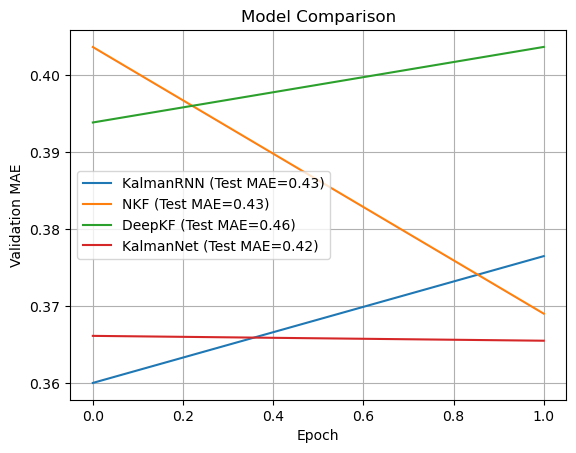

In [29]:
#def run_model(model_name, model_class, dataloaders, device):
def run_model(model_name, model_class, device):
    state_dim, obs_dim, exog_dim = 64, 1, 24
    #model = model_class(state_dim, obs_dim, exog_dim).to(device)
    if model_name == 'DeepKF':
        model = model_class(obs_dim, state_dim, exog_dim).to(device)
    elif model_name == 'KalmanNet':
        model = model_class(obs_dim, state_dim, exog_dim).to(device)
    else:
        model = model_class(state_dim, obs_dim, exog_dim).to(device)

    head = LSTMHead(state_dim, 64).to(device)

    optimizer = torch.optim.Adam(list(model.parameters()) + list(head.parameters()), lr=1e-3)
    loss_fn = nn.MSELoss()
    early_stop_patience = 5

    #train_loader, val_loader, test_loader = dataloaders
    best_val = float('inf')
    patience = 0

    train_losses, val_maes = [], []
    for epoch in range(2):
        loss = train(model, head, train_loader, optimizer, loss_fn, device)
        val_mae = evaluate(model, head, val_loader, device)
        train_losses.append(loss)
        val_maes.append(val_mae)
        if val_mae < best_val:
            best_val = val_mae
            patience = 0
        else:
            patience += 1
            if patience > early_stop_patience:
                break

    test_mae = evaluate(model, head, test_loader, device)
    print(f"{model_name} Test MAE: {test_mae:.4f}")
    return train_losses, val_maes, test_mae

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #dataloaders = get_dataloaders()
    results = {}
    for name, model_cls in {
        'KalmanRNN': KalmanRNN,
        'NKF': NKF,
        #'RTSNet': RTSNet, 
        'DeepKF': DeepKF,
        'KalmanNet': KalmanNet,
    }.items():
        print(f"\n==> Running {name}...")
        #losses, val_maes, test_mae = run_model(name, model_cls, dataloaders, device)
        losses, val_maes, test_mae = run_model(name, model_cls, device)
        results[name] = (losses, val_maes, test_mae)

    plot_metrics(results)


In [2]:
import os
import pickle
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# === Dataset === #
class METRLADataset(Dataset):
    def __init__(self, data, adj, exog=None, seq_len=12, pred_len=12):
        self.data = data
        self.adj = adj
        self.exog = exog
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.num_nodes = data.shape[0]
        self.num_timesteps = data.shape[1]

    def __len__(self):
        return self.num_timesteps - self.seq_len - self.pred_len + 1

    def __getitem__(self, idx):
        X = self.data[:, idx:idx+self.seq_len, :]
        Y = self.data[:, idx+self.seq_len:idx+self.seq_len+self.pred_len, 0]
        if self.exog is not None:
            U = self.exog[idx:idx+self.seq_len]
            U = np.repeat(U[np.newaxis, :, :], self.num_nodes, axis=0)
        else:
            U = np.zeros((self.num_nodes, self.seq_len, 0))
        return (
            torch.tensor(X, dtype=torch.float32),
            torch.tensor(U, dtype=torch.float32),
            torch.tensor(Y, dtype=torch.float32),
        )

def load_adj(path):
    with open(path, 'rb') as f:
        return pickle.load(f, encoding='latin1')

def create_time_exog(num_timesteps):
    hours = np.arange(num_timesteps) % 24
    return np.eye(24)[hours].astype(np.float32)

def load_metrla_dataframe(path):
    import pandas as pd
    df = pd.read_hdf(path)
    return df.values

def prepare_dataloaders(data_path, adj_path, batch_size=64, seq_len=12, pred_len=12):
    data = load_metrla_dataframe(data_path)
    data = data.T[:, :, None] if data.ndim == 2 else data
    adj = load_adj(adj_path)
    nodes, timesteps, features = data.shape

    scaler = StandardScaler()
    reshaped = data.reshape(nodes * timesteps, features)
    norm_data = scaler.fit_transform(reshaped).reshape(nodes, timesteps, features)
    exog = create_time_exog(timesteps)

    train_end = int(0.7 * timesteps)
    val_end = int(0.8 * timesteps)

    train_ds = METRLADataset(norm_data[:, :train_end, :], adj, exog[:train_end], seq_len, pred_len)
    val_ds   = METRLADataset(norm_data[:, train_end - seq_len - pred_len:val_end, :], adj, exog[train_end - seq_len - pred_len:val_end], seq_len, pred_len)
    test_ds  = METRLADataset(norm_data[:, val_end - seq_len - pred_len:, :], adj, exog[val_end - seq_len - pred_len:], seq_len, pred_len)

    def collate_fn(batch):
        X = torch.stack([b[0] for b in batch])
        U = torch.stack([b[1] for b in batch])
        Y = torch.stack([b[2] for b in batch])
        return X, U, Y

    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn),
        DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn),
        DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn),
        scaler
    )

# === KalmanRNN === #
class KalmanRNN(nn.Module):
    def __init__(self, state_dim, obs_dim, exog_dim):
        super().__init__()
        self.A = nn.Parameter(torch.eye(state_dim))
        self.B = nn.Parameter(torch.randn(state_dim, exog_dim) * 0.01)
        self.C = nn.Parameter(torch.randn(obs_dim, state_dim) * 0.01)
        self.Q = nn.Parameter(torch.eye(state_dim))
        self.R = nn.Parameter(torch.eye(obs_dim))
        self.gru = nn.GRU(obs_dim + exog_dim, state_dim, batch_first=True)

    def forward(self, Y, U):
        B, N, T, obs_dim = Y.shape
        _, _, _, exog_dim = U.shape
        YU = torch.cat([Y, U], dim=-1).reshape(B * N, T, obs_dim + exog_dim)
        h0 = torch.zeros(1, B * N, self.A.shape[0]).to(Y.device)
        h, _ = self.gru(YU, h0)
        h = h.view(B, N, T, -1)
        h = torch.matmul(h, self.A.T)
        U_flat = U.view(B * N, T, exog_dim)
        U_applied = torch.matmul(U_flat, self.B.T).view(B, N, T, -1)
        return h + U_applied

# === Forecasting Head (multi-step) === #
class LSTMHead(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=12):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, h):
        B, N, T, F = h.shape
        h = h.view(B * N, T, F)
        _, (hn, _) = self.lstm(h)
        out = self.fc(hn[-1])
        return out.view(B, N, -1)

# === Train/Eval === #
def train(model, head, dataloader, optimizer, loss_fn, device):
    model.train()
    total = 0
    for X, U, Y in dataloader:
        X, U, Y = X.to(device), U.to(device), Y.to(device)
        optimizer.zero_grad()
        h = model(X, U)
        pred = head(h)
        loss = loss_fn(pred, Y)
        loss.backward()
        optimizer.step()
        total += loss.item()
        checkpoint_path = os.path.join("checkpoints", f"epoch_{epoch}.pt")
        torch.save(model.state_dict(), checkpoint_path)
    return total / len(dataloader)



@torch.no_grad()
def evaluate(model, head, dataloader, device):
    model.eval()
    errors = []
    for X, U, Y in dataloader:
        X, U, Y = X.to(device), U.to(device), Y.to(device)
        h = model(X, U)
        pred = head(h)
        mae = torch.mean(torch.abs(pred - Y))
        errors.append(mae.item())
    return sum(errors) / len(errors)

# === Main Runner === #
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, val_loader, test_loader, _ = prepare_dataloaders(
        data_path="METR-LA.h5",
        adj_path="adj_METR-LA.pkl",
        batch_size=64,
        seq_len=12,
        pred_len=12
    )

    model = KalmanRNN(state_dim=64, obs_dim=1, exog_dim=24).to(device)
    head = LSTMHead(input_dim=64, hidden_dim=64, output_dim=12).to(device)
    optimizer = torch.optim.Adam(list(model.parameters()) + list(head.parameters()), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(10):
        train_loss = train(model, head, train_loader, optimizer, loss_fn, device)
        val_mae = evaluate(model, head, val_loader, device)
        print(f"Epoch {epoch:2d} | Train Loss: {train_loss:.4f} | Val MAE: {val_mae:.4f}")

    test_mae = evaluate(model, head, test_loader, device)
    print(f"Final Test MAE: {test_mae:.4f}")

Epoch  0 | Train Loss: 0.3118 | Val MAE: 0.2758
Epoch  1 | Train Loss: 0.2736 | Val MAE: 0.2569
Epoch  2 | Train Loss: 0.2720 | Val MAE: 0.2710
Epoch  3 | Train Loss: 0.2717 | Val MAE: 0.2684
Epoch  4 | Train Loss: 0.2704 | Val MAE: 0.2594
Epoch  5 | Train Loss: 0.2694 | Val MAE: 0.2678
Epoch  6 | Train Loss: 0.2695 | Val MAE: 0.2771
Epoch  7 | Train Loss: 0.2686 | Val MAE: 0.2750
Epoch  8 | Train Loss: 0.2678 | Val MAE: 0.2640
Epoch  9 | Train Loss: 0.2674 | Val MAE: 0.2747
Final Test MAE: 0.3091


In [3]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_matrix_heatmap(matrix, title, save_path=None):
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix.cpu().detach().numpy(), cmap="viridis", annot=False)
    plt.title(title)
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.close()

def track_kalman_matrices(model_checkpoints, save_dir="matrix_evolution"):
    os.makedirs(save_dir, exist_ok=True)
    for epoch, path in enumerate(model_checkpoints):
        state_dict = torch.load(path, map_location="cpu")
        A = state_dict.get("A") or state_dict.get("module.A")
        B = state_dict.get("B") or state_dict.get("module.B")
        C = state_dict.get("C") or state_dict.get("module.C")
        
        if A is not None:
            plot_matrix_heatmap(A, f"A Matrix - Epoch {epoch}", os.path.join(save_dir, f"A_epoch{epoch}.png"))
        if B is not None:
            plot_matrix_heatmap(B, f"B Matrix - Epoch {epoch}", os.path.join(save_dir, f"B_epoch{epoch}.png"))
        if C is not None:
            plot_matrix_heatmap(C, f"C Matrix - Epoch {epoch}", os.path.join(save_dir, f"C_epoch{epoch}.png"))

# Example usage:
# model_checkpoints = ["checkpoints/epoch_0.pt", "checkpoints/epoch_1.pt", ...]
# track_kalman_matrices(model_checkpoints)


In [4]:
import os
import glob
from visualize_kalman_matrices import track_kalman_matrices

# Automatically gather all checkpoint files from the directory and sort them
checkpoint_dir = "checkpoints"
model_checkpoints = sorted(
    glob.glob(os.path.join(checkpoint_dir, "epoch_*.pt")),
    key=lambda x: int(x.split("_")[-1].split(".")[0])  # extract epoch number
)
def track_kalman_matrices(model_checkpoints, save_dir="matrix_evolution"):
    import os
    import torch
    import matplotlib.pyplot as plt
    import seaborn as sns

    os.makedirs(save_dir, exist_ok=True)

    def plot_matrix_heatmap(matrix, title, save_path=None):
        plt.figure(figsize=(6, 5))
        sns.heatmap(matrix.cpu().detach().numpy(), cmap="viridis", annot=False)
        plt.title(title)
        plt.xlabel("Columns")
        plt.ylabel("Rows")
        if save_path:
            plt.savefig(save_path, bbox_inches="tight")
        plt.close()

    for epoch, path in enumerate(model_checkpoints):
        state_dict = torch.load(path, map_location="cpu")

        A = state_dict.get("A") if state_dict.get("A") is not None else state_dict.get("module.A")
        B = state_dict.get("B") if state_dict.get("B") is not None else state_dict.get("module.B")
        C = state_dict.get("C") if state_dict.get("C") is not None else state_dict.get("module.C")

        if A is not None:
            plot_matrix_heatmap(A, f"A Matrix - Epoch {epoch}", os.path.join(save_dir, f"A_epoch{epoch}.png"))
        if B is not None:
            plot_matrix_heatmap(B, f"B Matrix - Epoch {epoch}", os.path.join(save_dir, f"B_epoch{epoch}.png"))
        if C is not None:
            plot_matrix_heatmap(C, f"C Matrix - Epoch {epoch}", os.path.join(save_dir, f"C_epoch{epoch}.png"))

# Visualize learned matrices across epochs
track_kalman_matrices(model_checkpoints, save_dir="matrix_evolution")


C:\Users\Suraj Kumar\AppData\Local\Temp\ipykernel_18088\2152764740.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location="cpu")
C:\

In [ ]:
def run_ablation(model, head, name):
    optimizer = torch.optim.Adam(list(model.parameters()) + list(head.parameters()), lr=1e-3)
    loss_fn = torch.nn.MSELoss()
    best_val = float('inf')
    patience, early_stop = 0, 5
    train_losses, val_maes = [], []
    
    for epoch in range(10):
        loss = train(model, head, train_loader, optimizer, loss_fn, device)
        val_mae = evaluate(model, head, val_loader, device)
        train_losses.append(loss)
        val_maes.append(val_mae)
        if val_mae < best_val:
            best_val = val_mae
            patience = 0
        else:
            patience += 1
            if patience > early_stop:
                break
    test_mae = evaluate(model, head, test_loader, device)
    print(f"{name} Test MAE: {test_mae:.4f}")
    return train_losses, val_maes, test_mae

results = {}

# 1. Full KalmanRNN
model = KalmanRNN(state_dim=64, obs_dim=1, exog_dim=24).to(device)
head = LSTMHead(64, 64).to(device)
results["KalmanRNN (Full)"] = run_ablation(model, head, "KalmanRNN (Full)")

# 2. KalmanRNN without learnable Kalman matrices (GRU only)
class KalmanRNN_wo_Kalman(nn.Module):
    def __init__(self, state_dim, obs_dim, exog_dim):
        super().__init__()
        self.gru = nn.GRU(obs_dim + exog_dim, state_dim, batch_first=True)

    def forward(self, Y, U):
        batch, nodes, T, obs_dim = Y.shape
        _, _, _, exog_dim = U.shape
        YU = torch.cat([Y, U], dim=-1)  # (batch, nodes, T, obs_dim + exog_dim)
        YU = YU.view(batch * nodes, T, obs_dim + exog_dim)
        h0 = torch.zeros(1, batch * nodes, self.gru.hidden_size).to(Y.device)
        h, _ = self.gru(YU, h0)
        h = h.view(batch, nodes, T, -1)
        return h


model = KalmanRNN_wo_Kalman(state_dim=64, obs_dim=1, exog_dim=24).to(device)
head = LSTMHead(64, 64).to(device)
results["KalmanRNN w/o Kalman"] = run_ablation(model, head, "KalmanRNN w/o Kalman")

# 3. KalmanRNN without GRU (Kalman matrices only)
import torch.nn as nn

class KalmanRNN_wo_GRU(nn.Module):
    def __init__(self, state_dim, obs_dim, exog_dim):
        super().__init__()
        self.A = nn.Parameter(torch.eye(state_dim))
        self.B = nn.Parameter(torch.randn(state_dim, exog_dim))
        self.C = nn.Parameter(torch.randn(obs_dim, state_dim))
        self.Q = nn.Parameter(torch.eye(state_dim))
        self.R = nn.Parameter(torch.eye(obs_dim))

    def forward(self, Y, U):
        batch, nodes, T, obs_dim = Y.shape
        return Y.new_zeros(batch, nodes, T, 64)  # Dummy zero latent

model = KalmanRNN_wo_GRU(state_dim=64, obs_dim=1, exog_dim=24).to(device)
head = LSTMHead(64, 64).to(device)
results["KalmanRNN w/o GRU"] = run_ablation(model, head, "KalmanRNN w/o GRU")

# 4. GRU-only baseline (no Kalman parameters at all)
from torch import nn

class GRUOnly(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)

    def forward(self, Y, U):
        X = torch.cat([Y, U], dim=-1)
        B, N, T, F = X.shape
        X = X.view(B * N, T, F)
        h0 = torch.zeros(1, B * N, self.gru.hidden_size).to(X.device)
        h, _ = self.gru(X, h0)
        return h.view(B, N, T, -1)

model = GRUOnly(input_dim=1+24, hidden_dim=64).to(device)
head = LSTMHead(64, 64).to(device)
results["GRU Only"] = run_ablation(model, head, "GRU Only")



KalmanRNN (Full) Test MAE: 0.2996
KalmanRNN w/o Kalman Test MAE: 0.3023
KalmanRNN w/o GRU Test MAE: 0.8170
GRU Only Test MAE: 0.3021


NameError: name 'plot_metrics' is not defined

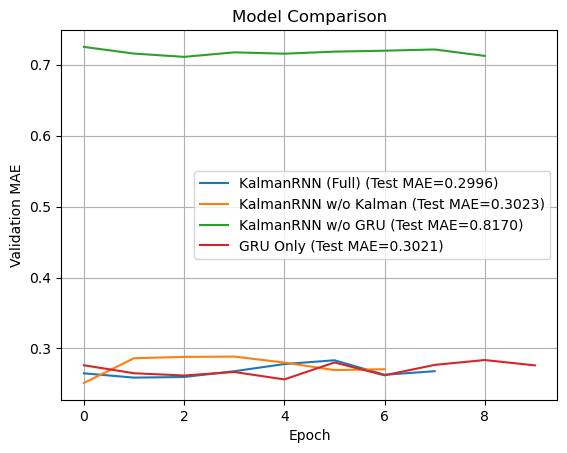

In [8]:
def plot_metrics(results):
    for name, (losses, val_maes, test_mae) in results.items():
        plt.plot(val_maes, label=f"{name} (Test MAE={test_mae:.4f})")
    plt.xlabel("Epoch")
    plt.ylabel("Validation MAE")
    plt.legend()
    plt.title("Model Comparison")
    plt.grid(True)
    plt.show()
plot_metrics(results)

In [16]:
!pip install torch-geometric

Defaulting to user installation because normal site-packages is not writeable


In [2]:
#!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -q

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Dummy VRP Environment === #
class VRPEnvGNN:
    def __init__(self, coords, demands, ready, due, service, capacity, duals):
        self.coords = coords
        self.demands = demands
        self.capacity = capacity
        self.duals = duals
        self.visited = set()
        self.cur_node = 0
        self.load = 0
        self.route = [0]
        self.step_count = 0

    def reset(self):
        self.visited = set([0])
        self.cur_node = 0
        self.load = 0
        self.route = [0]
        self.step_count = 0
        return self._make_state()

    def step(self, action):
        self.visited.add(action)
        self.load += self.demands[action]
        self.route.append(action)
        self.cur_node = action
        self.step_count += 1
        done = self.load >= self.capacity or len(self.visited) == len(self.coords)
        return self._make_state(), done

    def get_masked_actions(self):
        return [i for i in range(len(self.coords)) if i not in self.visited and self.load + self.demands[i] <= self.capacity]

    def finish(self):
        pass

    def reward(self):
        return -len(self.route)  # Penalize long routes

    def _make_state(self):
        x = []
        for i in range(len(self.coords)):
            x.append(self.coords[i].tolist() + [self.demands[i], self.duals[i], float(i in self.visited)])
        x = torch.tensor(x, dtype=torch.float32)
        edge_index = torch.tensor([[i, j] for i in range(len(x)) for j in range(len(x)) if i != j], dtype=torch.long).t().contiguous()
        batch = torch.zeros(len(x), dtype=torch.long)
        return Data(x=x, edge_index=edge_index, batch=batch)

# === GNN PPO Actor-Critic === #
class GNNActorCritic(nn.Module):
    def __init__(self, node_feat_dim, hidden_dim, num_actions):
        super().__init__()
        self.gnn1 = GCNConv(node_feat_dim, hidden_dim)
        self.gnn2 = GCNConv(hidden_dim, hidden_dim)
        self.actor_head = nn.Linear(hidden_dim, 1)
        self.critic_head = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index, batch):
        h = F.relu(self.gnn1(x, edge_index))
        h = F.relu(self.gnn2(h, edge_index))
        graph = global_mean_pool(h, batch)
        logits = self.actor_head(h).squeeze()
        value = self.critic_head(graph).mean()
        return logits, value

# === PPO Trainer === #
class PPOTrainer:
    def __init__(self, model, lr=1e-3, gamma=0.99, clip_eps=0.2, value_coeff=0.5, entropy_coeff=0.01):
        self.model = model
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.gamma = gamma
        self.clip_eps = clip_eps
        self.value_coeff = value_coeff
        self.entropy_coeff = entropy_coeff
        self.device = next(model.parameters()).device

    def compute_advantages(self, rewards, values, next_value):
        returns = []
        G = next_value
        for r in reversed(rewards):
            G = r + self.gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32, device=self.device)
        values = values.to(self.device)
        return returns, returns - values

    def ppo_update(self, data_batch, actions, old_log_probs, returns, advantages, epochs=2):
        for _ in range(epochs):
            logits, values = self.model(data_batch.x, data_batch.edge_index, data_batch.batch)
            dist = Categorical(logits=logits)
            actions = actions.to(self.device)
            new_log_probs = dist.log_prob(actions)
            ratio = torch.exp(new_log_probs - old_log_probs)
            actor_loss = -torch.min(ratio * advantages, torch.clamp(ratio, 1 - self.clip_eps, 1 + self.clip_eps) * advantages).mean()
            critic_loss = F.mse_loss(values, returns)
            loss = actor_loss + self.value_coeff * critic_loss
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

# === Rollout === #
def rollout_episode(env, model):
    data_list, actions, log_probs, values = [], [], [], []
    done = False
    state = env.reset().to(device)

    with torch.no_grad():
        while not done:
            logits, value = model(state.x, state.edge_index, state.batch)
            masked = env.get_masked_actions()
            if not masked:
                break
            mask = torch.zeros_like(logits)
            mask[masked] = 1.0
            probs = torch.softmax(logits * mask, dim=0)
            dist = Categorical(probs)
            action = dist.sample()
            data_list.append(state)
            actions.append(action)
            log_probs.append(dist.log_prob(action))
            values.append(value)
            state, done = env.step(action.item())
            state = state.to(device)

    env.finish()
    final_reward = env.reward()
    return data_list, actions, log_probs, values, [final_reward] * len(actions)

# === Train === #
def train():
    coords = np.array([[35, 35], [41, 49], [35, 17], [55, 45], [55, 20], [15, 30]])
    demands = [0, 10, 7, 13, 19, 26]
    duals = [0, 5, 6, 4, 3, 7]
    ready, due, service = [0]*6, [0]*6, [0]*6
    capacity = 50

    env = VRPEnvGNN(coords, demands, ready, due, service, capacity, duals)
    model = GNNActorCritic(node_feat_dim=5, hidden_dim=32, num_actions=len(coords)).to(device)
    trainer = PPOTrainer(model)

    for epoch in range(5):
        data_batch, actions, log_probs, values, rewards = [], [], [], [], []
        for _ in range(2):
            d, a, l, v, r = rollout_episode(env, model)
            data_batch += d
            actions += a
            log_probs += l
            values += v
            rewards += r
        batch = Batch.from_data_list(data_batch).to(device)
        actions = torch.stack(actions).to(device)
        log_probs = torch.stack(log_probs).to(device)
        values = torch.stack(values).squeeze().to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
        returns, advantages = trainer.compute_advantages(rewards, values.detach(), 0)
        trainer.ppo_update(batch, actions, log_probs, returns, advantages)
        print(f"Epoch {epoch} mean reward: {rewards.mean().item():.2f}")

train()


C:\Users\Suraj Kumar\AppData\Local\Temp\ipykernel_1608\3489874347.py:108: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, returns)


Epoch 0 mean reward: -54.85


C:\Users\Suraj Kumar\AppData\Local\Temp\ipykernel_1608\3489874347.py:108: UserWarning: Using a target size (torch.Size([52])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, returns)


Epoch 1 mean reward: -27.96


C:\Users\Suraj Kumar\AppData\Local\Temp\ipykernel_1608\3489874347.py:108: UserWarning: Using a target size (torch.Size([146])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, returns)


Epoch 2 mean reward: -123.32


C:\Users\Suraj Kumar\AppData\Local\Temp\ipykernel_1608\3489874347.py:108: UserWarning: Using a target size (torch.Size([129])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, returns)


Epoch 3 mean reward: -81.88
Epoch 4 mean reward: -53.50


C:\Users\Suraj Kumar\AppData\Local\Temp\ipykernel_1608\3489874347.py:108: UserWarning: Using a target size (torch.Size([84])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, returns)


In [21]:
import pandas as pd
df = pd.read_hdf("METR-LA.h5")
data = df.values

In [22]:
data.shape

(34272, 207)

In [23]:
with open('adj_METR-LA.pkl', 'rb') as f:
    adj = pickle.load(f, encoding='latin1')

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
import h5py
import pickle

speed_data = data

sensor_ids, sensor_id_to_ind, adj_mx = adj

# Handle zero speed entries
speed_data[speed_data == 0] = np.nan
speed_data = np.nan_to_num(speed_data, nan=np.nanmean(speed_data))

T, N = speed_data.shape
travel_times = 1.0 / (speed_data + 1e-3)  # Avoid division by zero
travel_times = np.clip(travel_times, 0, 10)  # Reasonable max time

# Normalize and reshape to [T, N, N]
travel_tensor = np.zeros((T, N, N))
for t in range(T):
    travel_tensor[t] = np.abs(np.subtract.outer(travel_times[t], travel_times[t]))

# === Environment === #
class VRPEnvDynamic:
    def __init__(self, coords, demands, travel_times, capacity, duals):
        self.coords = coords
        self.demands = demands
        self.travel_times = travel_times  # shape: [T, N, N]
        self.capacity = capacity
        self.duals = duals
        self.reset()

    def reset(self):
        self.t = 0
        self.visited = set([0])
        self.cur_node = 0
        self.load = 0
        self.route = [0]
        return self._make_state()

    def step(self, action):
        self.visited.add(action)
        self.load += self.demands[action]
        self.route.append(action)
        self.cur_node = action
        self.t = min(self.t + 1, self.travel_times.shape[0] - 1)
        done = self.load >= self.capacity or len(self.visited) == len(self.coords)
        return self._make_state(), done

    def get_masked_actions(self):
        return [i for i in range(len(self.coords)) if i not in self.visited and self.load + self.demands[i] <= self.capacity]

    def reward(self):
        total_cost = 0
        for i in range(1, len(self.route)):
            prev, cur = self.route[i - 1], self.route[i]
            total_cost += self.travel_times[self.t, prev, cur]
        return -total_cost

    def _make_state(self):
        x = []
        for i in range(len(self.coords)):
            x.append(self.coords[i].tolist() + [self.demands[i], self.duals[i], float(i in self.visited)])
        x = torch.tensor(x, dtype=torch.float32)
        edge_index = torch.tensor([[i, j] for i in range(len(x)) for j in range(len(x)) if i != j], dtype=torch.long).t().contiguous()
        batch = torch.zeros(len(x), dtype=torch.long)
        return Data(x=x, edge_index=edge_index, batch=batch)

# === Model === #
class GNNActorCritic(nn.Module):
    def __init__(self, node_feat_dim, hidden_dim, num_actions):
        super().__init__()
        self.gnn1 = GCNConv(node_feat_dim, hidden_dim)
        self.gnn2 = GCNConv(hidden_dim, hidden_dim)
        self.actor_head = nn.Linear(hidden_dim, 1)
        self.critic_head = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index, batch):
        h = F.relu(self.gnn1(x, edge_index))
        h = F.relu(self.gnn2(h, edge_index))
        graph = global_mean_pool(h, batch)
        logits = self.actor_head(h).squeeze()
        value = self.critic_head(graph).mean()
        return logits, value

# === PPO Trainer === #
class PPOTrainer:
    def __init__(self, model, lr=1e-3, gamma=0.99, clip_eps=0.2, value_coeff=0.5, entropy_coeff=0.01):
        self.model = model
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.gamma = gamma
        self.clip_eps = clip_eps
        self.value_coeff = value_coeff
        self.entropy_coeff = entropy_coeff
        self.device = next(model.parameters()).device

    def compute_advantages(self, rewards, values, next_value):
        returns = []
        G = next_value
        for r in reversed(rewards):
            G = r + self.gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32, device=self.device)
        values = values.to(self.device)
        return returns, returns - values

    def ppo_update(self, data_batch, actions, old_log_probs, returns, advantages, epochs=2):
        for _ in range(epochs):
            logits, values = self.model(data_batch.x, data_batch.edge_index, data_batch.batch)
            dist = Categorical(logits=logits)
            actions = actions.to(self.device)
            new_log_probs = dist.log_prob(actions)
            ratio = torch.exp(new_log_probs - old_log_probs)
            actor_loss = -torch.min(ratio * advantages, torch.clamp(ratio, 1 - self.clip_eps, 1 + self.clip_eps) * advantages).mean()
            critic_loss = F.mse_loss(values, returns)
            loss = actor_loss + self.value_coeff * critic_loss
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

# === Rollout === #
def rollout_episode(env, model, device):
    data_list, actions, log_probs, values = [], [], [], []
    done = False
    state = env.reset().to(device)

    with torch.no_grad():
        while not done:
            logits, value = model(state.x, state.edge_index, state.batch)
            masked = env.get_masked_actions()
            if not masked:
                break
            mask = torch.zeros_like(logits)
            mask[masked] = 1.0
            probs = torch.softmax(logits * mask, dim=0)
            dist = Categorical(probs)
            action = dist.sample()
            data_list.append(state)
            actions.append(action)
            log_probs.append(dist.log_prob(action))
            values.append(value)
            state, done = env.step(action.item())
            state = state.to(device)

    final_reward = env.reward()
    return data_list, actions, log_probs, values, [final_reward] * len(actions)

# === Training Loop === #
def train_metrla_vrp():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    coords = np.random.rand(N, 2)
    demands = np.random.randint(1, 10, size=N)
    duals = np.random.rand(N)
    capacity = 100

    env = VRPEnvDynamic(coords, demands, travel_times[:100], capacity, duals)
    model = GNNActorCritic(node_feat_dim=5, hidden_dim=64, num_actions=N).to(device)
    trainer = PPOTrainer(model)

    for epoch in range(10):
        data_batch, actions, log_probs, values, rewards = [], [], [], [], []
        for _ in range(4):
            d, a, l, v, r = rollout_episode(env, model, device)
            data_batch += d
            actions += a
            log_probs += l
            values += v
            rewards += r
        batch = Batch.from_data_list(data_batch).to(device)
        actions = torch.stack(actions).to(device)
        log_probs = torch.stack(log_probs).to(device)
        values = torch.stack(values).squeeze().to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
        returns, advantages = trainer.compute_advantages(rewards, values.detach(), 0)
        trainer.ppo_update(batch, actions, log_probs, returns, advantages)
        print(f"Epoch {epoch} mean reward: {rewards.mean().item():.2f}")

train_metrla_vrp()


MemoryError: Unable to allocate 10.9 GiB for an array with shape (34272, 207, 207) and data type float64